In [1]:
import pandas as pd
import networkx as nx
from torch_geometric_temporal.signal import temporal_signal_split
from src import EVEDataloader
from tqdm import tqdm

ModuleNotFoundError: No module named 'torch_geometric_temporal'

### NetworkX Chickenpox

In [7]:
# use networkx to load the base graph:
G = nx.read_gml("data/eve_online/galaxy_region_graph_coords_subgraph_typeid_262.gml")


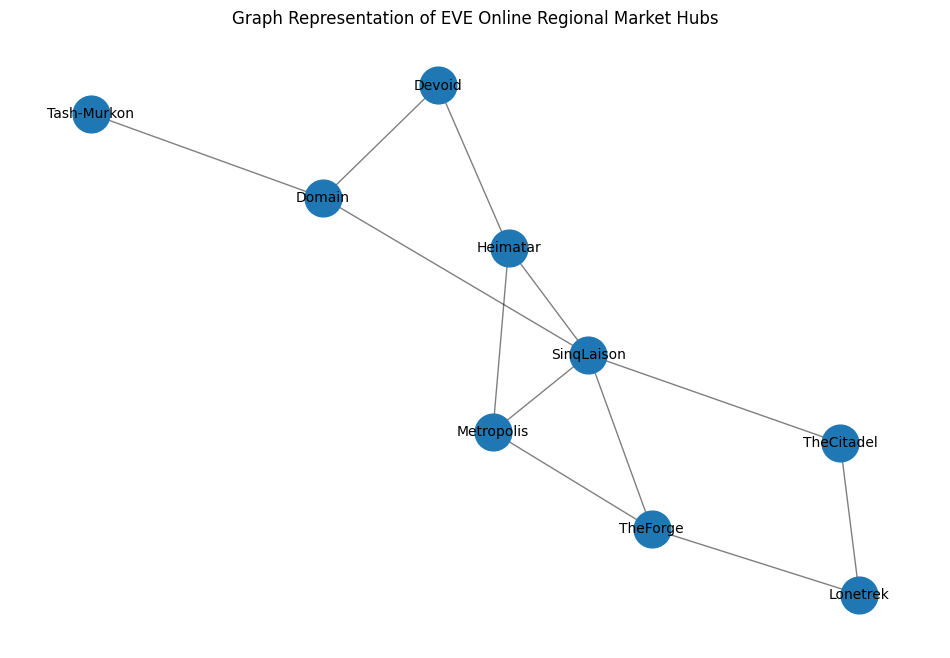

In [8]:
import matplotlib.pyplot as plt

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw_networkx_nodes(G, pos, node_size=700)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

plt.title("Graph Representation of EVE Online Regional Market Hubs")
plt.axis('off')  # Turn off the axis
plt.show()


### Torch Geometric Temporal:

In [9]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DCRNN

class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = DCRNN(node_features, 32, 1)
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

In [56]:
# Path to the JSON file
file_path = 'data/eve_online/eve_regionhubs_262_multifrequency_L_averag_7d_percentilee.json'
loader = EVEDataloader.EVEDataloader(file_path)

lags = 10
dataset = loader.get_dataset(lags=lags)

In [57]:
dataset_len = len(dataset.features)
train_dataset_len = int(dataset_len * 0.8)
train_end_idx = train_dataset_len - lags

In [58]:
train_dataset = dataset[:train_dataset_len]
test_dataset = dataset[train_end_idx:]

In [59]:
print(dataset.features)

[]


In [62]:
print(len(dataset.features[0]))

IndexError: list index out of range

In [63]:
print(train_dataset.features)

[]


# TODO: 
- add FW stats as a node
- add ships destroyed stats as a node


In [ ]:
model = RecurrentGCN(node_features = lags)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# import mse error function
from torch.nn import MSELoss
model.train()

for epoch in tqdm(range(200)):
    cost = 0
    loss = 0
    criterion = MSELoss()
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        loss = criterion(y_hat, snapshot)

        # loss = t?orch.tensor(loss, requires_grad=True) / torch.tensor((time+1), requires_grad=True)

        loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  0%|          | 0/200 [00:00<?, ?it/s]c:\Users\raphc\.conda\envs\torch_geometric\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size ((1434, 1434)) that is different to the input size (torch.Size([1434, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/200 [00:00<?, ?it/s]


TypeError: expected Tensor as element 1 in argument 0, but got Data

In [ ]:
import torch
import torch.nn.functional as F
from torch.optim import Adam
from tqdm import tqdm

model = RecurrentGCN(node_features=lags)
optimizer = Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(200)):
    cost = 0  # Reset cost at the start of each epoch
    num_batches = 0  # Counter to track number of batches
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        loss = torch.mean((y_hat - snapshot.y) ** 2)
        cost += loss.item()  # Accumulate the loss; convert loss to scalar if not using it for autograd directly here
        num_batches += 1

    # Average the cost over all time steps after the loop
    if num_batches > 0:  # Check to avoid division by zero
        cost = cost / num_batches
        cost_tensor = torch.tensor(cost, requires_grad=True)  # Create a tensor from the average cost

        # Perform backpropagation and optimizer steps
        optimizer.zero_grad()
        cost_tensor.backward()  # Backpropagate based on the average cost of the epoch
        optimizer.step()


100%|██████████| 200/200 [00:00<00:00, 200014.50it/s]


In [ ]:
model.eval()
cost = 0
costs = []
preds = []
gtruths = []
model.eval()
for time, snapshot in enumerate(test_dataset):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    # print(snapshot.x)
    
    pred = y_hat.detach().numpy()
    preds.append(pred)
    gtruth = snapshot.y.detach().numpy()
    gtruths.append(gtruth)
    

    print(f"Time: {time}, MSE: {cost}, Pred: {pred}, Ground Truth: {gtruth}")
print("MSE: {:.4f}".format(cost))

Time: 0, MSE: 0, Pred: [[0.1659256 ]
 [0.17966679]
 [0.17079017]
 ...
 [0.16018769]
 [0.1642881 ]
 [0.17012957]], Ground Truth: [1.        0.75      0.6666667 ... 0.5714286 0.5714286 0.5714286]
MSE: 0.0000


In [ ]:
import numpy as np
mae = np.mean(np.abs(pred - gtruth))

In [ ]:
mae

0.35104164

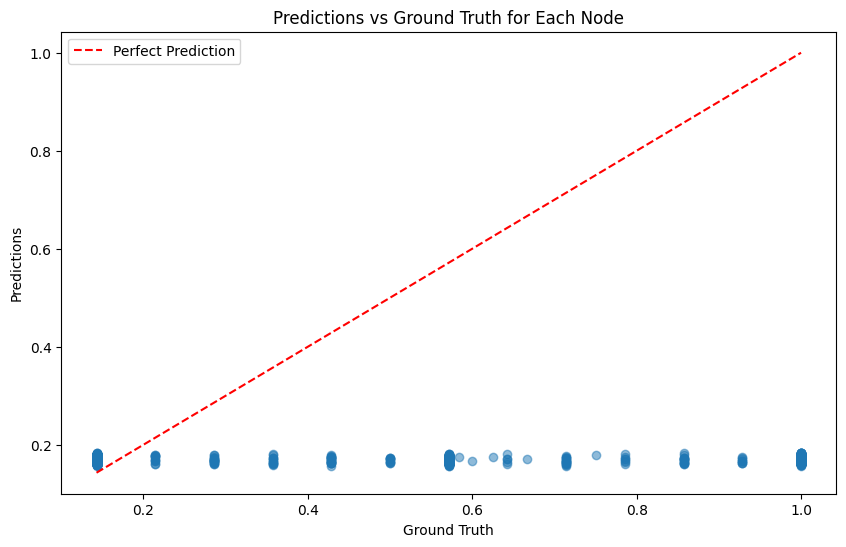

In [ ]:
import matplotlib.pyplot as plt

# Assuming `predictions` and `ground_truth` are lists or arrays of your data
predictions = preds[0]  # Replace with your predictions
ground_truth = gtruths[0] # Replace with your ground truth values

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(ground_truth, predictions, alpha=0.5)

# Plot a line representing perfect predictions for reference
plt.plot([min(ground_truth), max(ground_truth)], [min(ground_truth), max(ground_truth)], color='red', linestyle='--', label='Perfect Prediction')

# Labeling
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.title('Predictions vs Ground Truth for Each Node')
plt.legend()

# Show plot
plt.show()

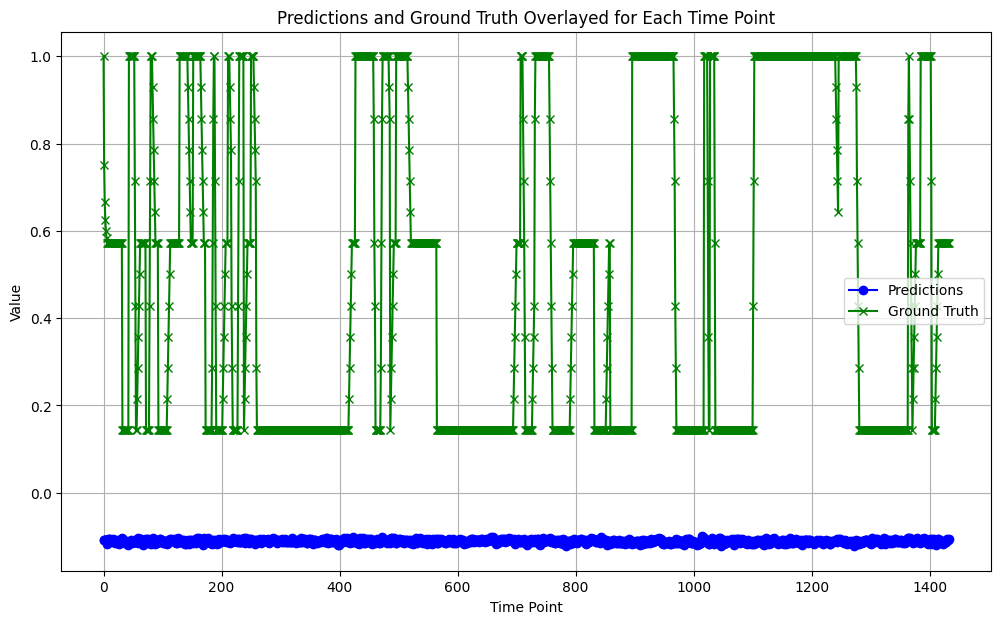

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data: Replace these with your actual data
time_points = np.arange(len(predictions))  # Assuming `predictions` and `ground_truth` have the same length
predictions = preds[0]# Your predictions array
ground_truth = gtruths[0]  # Your ground truth array

# Create a plot
plt.figure(figsize=(12, 7))

# Plotting both predictions and ground truth
plt.plot(time_points, predictions, label='Predictions', marker='o', linestyle='-', color='blue')
plt.plot(time_points, ground_truth, label='Ground Truth', marker='x', linestyle='-', color='green')

# Enhancements for better visualization
plt.xlabel('Time Point')
plt.ylabel('Value')
plt.title('Predictions and Ground Truth Overlayed for Each Time Point')
plt.legend()
plt.grid(True)

# Show plot
plt.show()